In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
import json

spark = SparkSession.builder \
    .appName("app_bronze_to_silver_mcc_codes") \
    .master("spark://spark-master:7077") \
    .config("spark.executor.memory", "1g") \
    .config("spark.executor.cores", "1") \
    .config("spark.cores.max", "1") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.hadoop.fs.s3a.endpoint", "http://minio:9000") \
    .config("spark.hadoop.fs.s3a.access.key", "minioadmin") \
    .config("spark.hadoop.fs.s3a.secret.key", "minioadmin123") \
    .config("spark.hadoop.fs.s3a.path.style.access", "true") \
    .config("spark.hadoop.fs.s3a.connection.ssl.enabled", "false") \
    .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
    .config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider") \
    .config("spark.jars.packages", 
            "org.apache.hadoop:hadoop-aws:3.3.4,"
            "com.amazonaws:aws-java-sdk-bundle:1.12.262,"
            "org.postgresql:postgresql:42.5.4") \
    .getOrCreate()

# Read the JSON file as a single string
raw_rdd = spark.sparkContext.wholeTextFiles("s3a://bronze/mcc_codes/mcc_codes.json").map(lambda x: x[1])

# Parse JSON string into Python dict
rdd_parsed = raw_rdd.map(lambda x: json.loads(x))

# Flatten dict into (key, value) pairs
rdd_flat = rdd_parsed.flatMap(lambda d: d.items())

rdd_transformed = rdd_flat.map(lambda x: (int(x[0]), x[1]))

# Convert to DataFrame
# df_src = rdd_flat.toDF(["mcc_code", "description"])

schema = StructType([
    StructField("mcc_code", IntegerType(), True),
    StructField("description", StringType(), True)
])

df_transformed = spark.createDataFrame(rdd_transformed, schema=schema)

df_transformed.show(5, truncate=False)

# Write to minio bucket
df_transformed.write.mode("overwrite").parquet("s3a://silver/mcc_codes/")

print("Data successfully loaded to Minio Bucket")

+--------+------------------------------------+
|mcc_code|description                         |
+--------+------------------------------------+
|5812    |Eating Places and Restaurants       |
|5541    |Service Stations                    |
|7996    |Amusement Parks, Carnivals, Circuses|
|5411    |Grocery Stores, Supermarkets        |
|4784    |Tolls and Bridge Fees               |
+--------+------------------------------------+
only showing top 5 rows

Data successfully loaded to Minio Bucket


In [2]:
print("Stopping spark session")
spark.stop()
print("spark session stopped successfully")

Stopping spark session
spark session stopped successfully


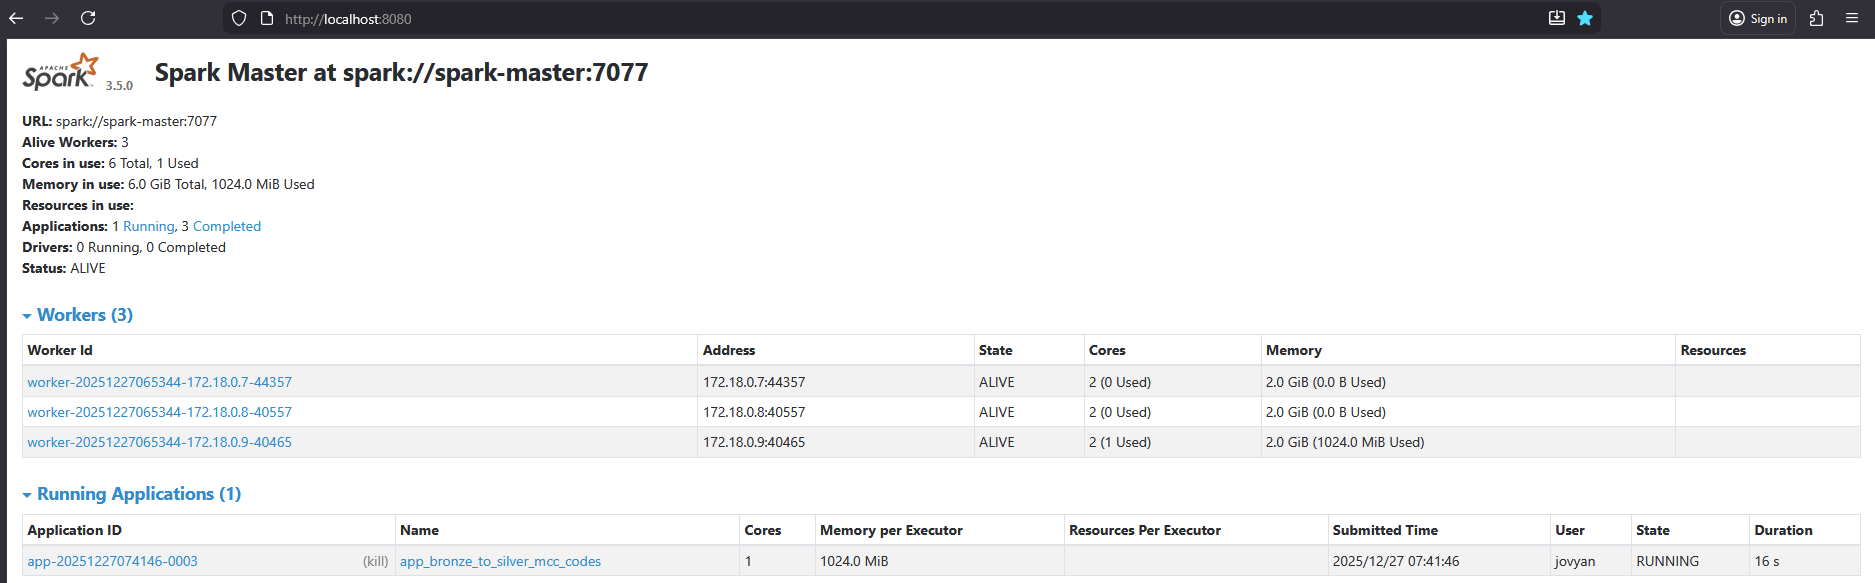

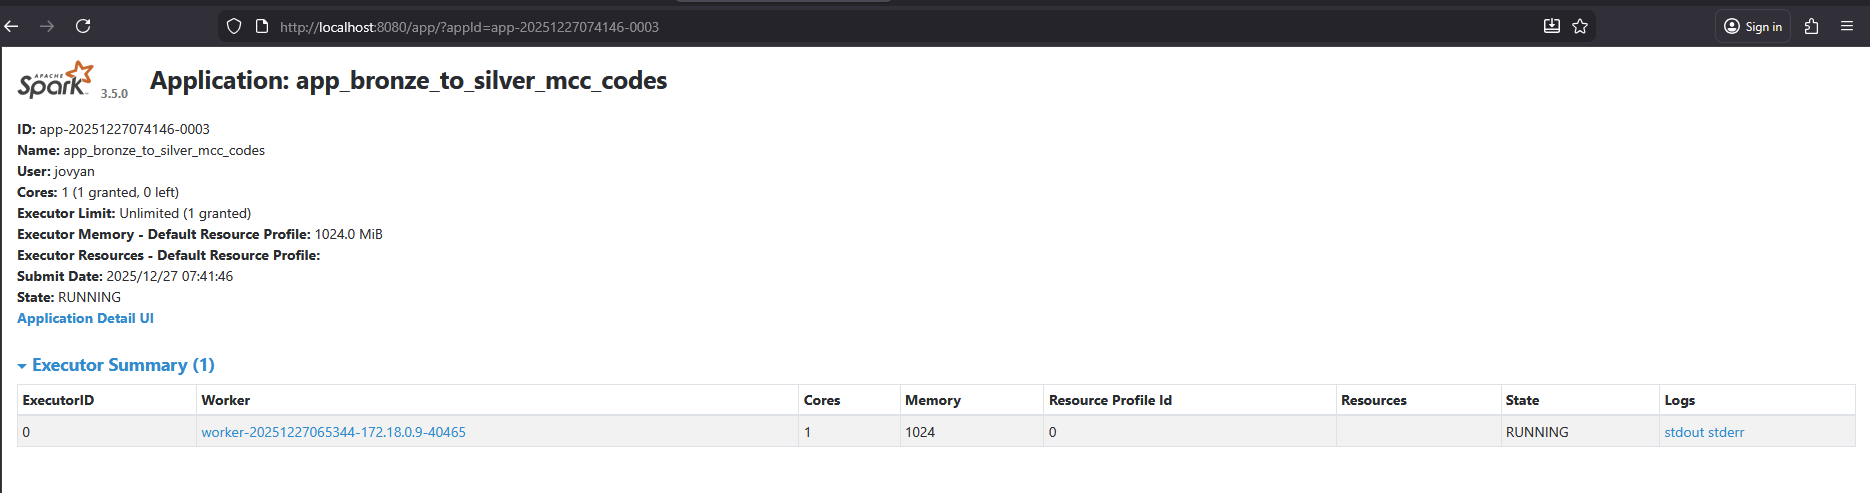